# Shallow Network Binary Prediction

### Setup

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data handeling and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Network
from keras.models import Sequential
from keras.layers import Input, Dense
from keras import callbacks
from tensorflow.keras.layers import InputLayer

from ann_visualizer.visualize import ann_viz;

### Read data

In [32]:
# Raw data
dftrain = pd.read_csv('loantrain.csv')

# Make working copy
train = dftrain.copy()

In [33]:
# View data for visual inspection
train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


### Preprosessing

In [34]:
# Remove Loan_ID
train = train.drop('Loan_ID',axis=1)

In [35]:
#Count of missing 
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Missing Values

In [36]:
# Imputtation of catagorical data - MODE
def mode_imput(data):
    str_list=['Gender','Married','Dependents','Self_Employed','Credit_History','Loan_Amount_Term']
    sizeofList = len(str_list)
    
    for column in data.columns:     
         for i in range(sizeofList):                    
            data[str_list[i]].fillna(data[str_list[i]].mode()[0], inplace=True)
        
    return data

In [37]:
# Imputtation of catagorical data - MEDIAN
def median_imput(data):
    str_list=['LoanAmount','ApplicantIncome','CoapplicantIncome']
    sizeofList = len(str_list)
    
    for column in data.columns:  
         for i in range(sizeofList):            
            data[str_list[i]].fillna(data[str_list[i]].median(), inplace=True)      
                    
    return data

In [38]:
# Call modal imputation function
train=mode_imput(train)

In [39]:
# Call median imputation function
train=median_imput(train)

In [40]:
# Map numerical values to catagorical data
def num_map(data):
    data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
    data['Married'] = data['Married'].map({'No': 0, 'Yes': 1})
    data['Dependents'] = data['Dependents'].map({'0': 0, '1': 1, '2': 2, '3+': 3})
    data['Education'] = data['Education'].map({'Graduate': 1, 'Not Graduate': 0})
    data['Self_Employed'] = data['Self_Employed'].map({'No': 0, 'Yes': 1})
    data['Property_Area'] = data['Property_Area'].map({'Rural': 0, 'Semiurban': 1, 'Urban': 2})
    data['Loan_Status'] = data['Loan_Status'].map({'N': 0, 'Y': 1})
        
    return data

In [41]:
# Call mapping function
train=num_map(train)

#### Normalise

In [42]:
# Function for min-max scaling
def min_max_scaling(data):
    for column in data.columns:
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())       
    return data

In [43]:
# Call min-max function
train = min_max_scaling(train)

In [44]:
# View processed data
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,0.0,0.000000,1.0,0.0,0.070489,0.000000,0.172214,0.743590,1.0,1.0,1.0
1,0.0,1.0,0.333333,1.0,0.0,0.054830,0.036192,0.172214,0.743590,1.0,0.0,0.0
2,0.0,1.0,0.000000,1.0,1.0,0.035250,0.000000,0.082489,0.743590,1.0,1.0,1.0
3,0.0,1.0,0.000000,0.0,0.0,0.030093,0.056592,0.160637,0.743590,1.0,1.0,1.0
4,0.0,0.0,0.000000,1.0,0.0,0.072356,0.000000,0.191027,0.743590,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,1.0,0.0,0.000000,1.0,0.0,0.034014,0.000000,0.089725,0.743590,1.0,0.0,1.0
610,0.0,1.0,1.000000,1.0,0.0,0.048930,0.000000,0.044863,0.358974,1.0,0.0,1.0
611,0.0,1.0,0.333333,1.0,0.0,0.097984,0.005760,0.353111,0.743590,1.0,1.0,1.0
612,0.0,1.0,0.666667,1.0,0.0,0.091936,0.000000,0.257598,0.743590,1.0,1.0,1.0


#### Split data

In [47]:
#Train data
# Remove target vairiable and store in seperate array
X_train = train.drop('Loan_Status',axis=1)
Y_train = train.Loan_Status

# Testing Data - 10%
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.1, stratify=train['Loan_Status'], random_state = 42)

# Split into training (80%) and validation (20%)
x_train, x_val, y_train, y_val = train_test_split (X_train, Y_train, test_size=0.2, stratify = Y_train, random_state = 42)
# Stratify ensure perameter proportionality in the split, based on Y_train in this case
# Random_state value provides a reproducable shuffle before the data is split


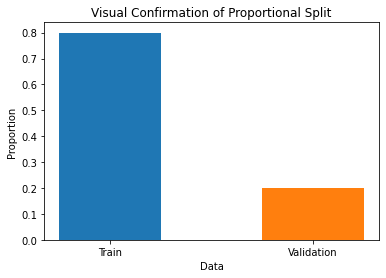

In [48]:
# Visual comfirmation of proportional split

# x_train as a percentage of train
plt.bar('Train',(x_train.count()/train.count()),align='center', width=-0.5)
# x_val as a percentage of train
plt.bar('Validation',(x_val.count()/train.count()), align='center', width=-0.5)

# Titles 
plt.xlabel('Data')
plt.ylabel('Proportion')
plt.title('Visual Confirmation of Proportional Split')

# Plot
plt.show()


### Model

#### Initial architecture

. Feedforward (Sequencial)

. Fully connected (Dense class)

. Single hidden layer

. 6 neurons in hidden layer (2/3 of input dimention)

. Relu activation function in hidden layer

. Sigmoid activation function in output layer

In [49]:
# build model with 1 hidden layer and sequencial single connecions
model = Sequential([
    Dense(units=6, activation='relu', input_shape=(x_train.shape[1], )),
    Dense(units=1, activation='sigmoid')
])

In [50]:
# Compile with optimiser, loss function, and accuracy metric
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
x=x_train
x.count()

Gender               491
Married              491
Dependents           491
Education            491
Self_Employed        491
ApplicantIncome      491
CoapplicantIncome    491
LoanAmount           491
Loan_Amount_Term     491
Credit_History       491
Property_Area        491
dtype: int64

In [52]:
y=y_train
y.count()

491

In [53]:
#Train network

# Avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
# Train
history = model.fit(x=x_train, y=y_train, epochs = 50, validation_data =(x_val, y_val), 
                    callbacks =[earlystopping])

Epoch 1/50
16/16 [==============================] - 1s 11ms/step - loss: 0.6618 - accuracy: 0.6762 - val_loss: 0.6469 - val_accuracy: 0.6829
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6843 - val_loss: 0.6327 - val_accuracy: 0.6911
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6864 - val_loss: 0.6203 - val_accuracy: 0.6992
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6843 - val_loss: 0.6094 - val_accuracy: 0.6992
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6864 - val_loss: 0.5998 - val_accuracy: 0.6911
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6864 - val_loss: 0.5914 - val_accuracy: 0.6911
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6098 - accuracy: 0.6864 - val_loss: 0.5855 - val_accuracy: 0.6911
Epoch 8/50
16/16 [=

In [54]:
# Accuracy of predictions from validation data
prediction = (model.predict(x_val) > 0.5).astype("int32")
print("Accuracy_Score : {}".format(accuracy_score(prediction, y_val) * 100))

Accuracy_Score : 85.36585365853658


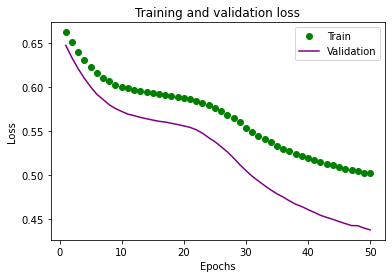

In [55]:
# Plot Loss Function
# Series
train_loss_series = history.history['loss']
val_loss_series = history.history['val_loss']

# Scale x-axis
epochs = range(1, len(train_loss_series) + 1) 

# plot
plt.plot(epochs, train_loss_series, 'go', label='Train')
plt.plot(epochs, val_loss_series, 'purple', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

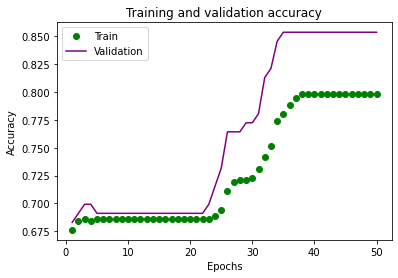

In [56]:
# Plot Accuracy
# Series
train_acc_series = history.history['accuracy']
val_acc_series = history.history['val_accuracy']

# Scale x-axsis
epochs = range(1, len(train_acc_series) + 1)

# plot
plt.plot(epochs, train_acc_series, 'go', label='Train')
plt.plot(epochs, val_acc_series, 'purple', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [57]:
# Run Trained Network

# see how these are numbers between 0 and 1? 
model.predict(x_test) # prob of successes (survival)
np.round(model.predict(x_test),0) # 1 and 0 (survival or not)
y_test # 1 and 0 (survival or not)

# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
preds = np.round(model.predict(x_test),0)

# confusion matrix
print(confusion_matrix(y_test, preds)) # order matters! (actual, predicted)
print(classification_report(y_test, preds))

[[ 9 10]
 [ 1 42]]
              precision    recall  f1-score   support

         0.0       0.90      0.47      0.62        19
         1.0       0.81      0.98      0.88        43

    accuracy                           0.82        62
   macro avg       0.85      0.73      0.75        62
weighted avg       0.84      0.82      0.80        62

